In [16]:
%matplotlib inline

In [17]:
from matplotlib.cm import get_cmap
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [18]:
sns.set(style='white')

## Explorativní analýza

V této části budeme pracovat s poměrně podrobnými daty - přímo s programy (řešeními), které uživatelé v Robotanikovi vyplňují. Tyto programy Tutor ukládá ve chvíli, kdy uživatelé spustí své řešení.

Nejprve si ujasníme terminologii, která je důležitá k pochopení dat:
- Uživatel může řešit jednu úlohu vícekrát - jednomu pokusu řešení budeme říkat **hra (game)**.
- V rámci jedné hry uživatel postupně buduje program, který hýbe Robotanikem. Program může uživatel kdykoliv spustit. My v datech pracujeme pouze s programy z posledního spuštění v rámci jedné hry.

In [19]:
# Pomoci knihovny pandas nacteme data
programs = pd.read_csv('data/robotanik-programs.csv')

In [20]:
# Abychom ziskali predstavu, jak data vypadaji, muzeme si vypsat nekolik prvnich radku tabulky
programs.head()

execution  game  max_recursion_depth  problem_id problem_name solved  time  \
0         10     1                    0         640       Schody   True     9   
1          1     1                    0         640       Schody  False    21   
2          2     1                    0         640       Schody   True     6   
3          2     1                    1         640       Schody   True     2   
4          3     1                    0         640       Schody   True     3   

   user_id                                            visited  
0        1  10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...  
1        2  10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...  
2    16387  10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...  
3        5  10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...  
4        6  10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...

### Popis dat
| Sloupec             | Popis               |
|---------------------|---------------------|
| execution           | číslo označující, kolikátému spuštění v rámci jedné hry záznam odpovídá         |
| game                | číslo označájící, kolikáté hře záznam odpovídá |
| max_recursion_depth | maximální hloubka rekurze při spuštění programu |
| problem_id          | ID zadání |
| problem_name        | název zadání |
| solved              | správnost řešení |
| time                | počet sekund uplynulých od začátku řešení problému |
| user_id             | ID uživatele |
| visited             | souřadnice postupně navštívených polí (řádek, sloupec); hrací plán ma maximálně 12 řádků a 16 sloupců |

In [21]:
# souradnice navstivenych poli potrebujeme zpracovat,
# protoze aktualne je ve sloupci [visited] pouze retezec
programs['visited'] = programs['visited'].apply(
    lambda visited: [coord.split(':') for coord in visited.split('|')]
)

In [22]:
# rovnez se nam bude hodit si ulozit pocet kroku Robotanika
programs['steps'] = programs['visited'].apply(len)
# s casem se casto pracuje na logaritmicke skale
programs['time_log'] = programs['time'].apply(lambda x: 0 if x == 0 else np.log(x))

In [23]:
# nase data tedy vypadaji takto
programs.head()

execution  game  max_recursion_depth  problem_id problem_name solved  time  \
0         10     1                    0         640       Schody   True     9   
1          1     1                    0         640       Schody  False    21   
2          2     1                    0         640       Schody   True     6   
3          2     1                    1         640       Schody   True     2   
4          3     1                    0         640       Schody   True     3   

   user_id                                            visited  steps  time_log  
0        1  [[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...     19  2.197225  
1        2  [[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...     19  3.044522  
2    16387  [[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...     19  1.791759  
3        5  [[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...     19  0.693147  
4        6  [[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...     19  1.098612

In [24]:
# dale si pripravime data tykajici jednotlivych uloh
def _apply(group):
    correct = group[group['solved']]
    wrong = group[~group['solved']]
    return pd.DataFrame([{
        'success': group['solved'].mean(),
        'time_all': group['time'].median(),
        'time_correct': correct['time'].median(),
        'time_wrong': wrong['time'].median(),
        'users': len(group['user_id'].unique()),
        'executions_all': group['execution'].median(),
        'executions_correct': correct['execution'].median(),
        'executions_wrong': wrong['execution'].median(),
        'steps_all': group['steps'].mean(),
        'steps_correct': correct['steps'].mean(),
        'steps_wrong': wrong['steps'].mean(),
        'recursion_all': group['max_recursion_depth'].median(),
        'recursion_correct': correct['max_recursion_depth'].median(),
        'recursion_wrong': wrong['max_recursion_depth'].median(),
    }])
problems = programs.groupby(['problem_id', 'problem_name']).apply(_apply).reset_index()
problems.head()

problem_id     problem_name  level_2  executions_all  executions_correct  \
0         636  Trénink rekurze        0             2.0                 2.0   
1         637   Trénink funkcí        0             3.0                 3.0   
2         638    Trénink barev        0             3.0                 3.0   
3         639          Cik cak        0             4.0                 4.0   
4         640           Schody        0             3.0                 3.0   

   executions_wrong  recursion_all  recursion_correct  recursion_wrong  \
0               1.0            0.0                0.0              0.0   
1               3.0            0.0                1.0              0.0   
2               2.0            0.0                0.0              0.0   
3               5.0            1.0                1.0              1.0   
4               3.0            0.0                0.0              0.0   

   steps_all  steps_correct  steps_wrong   success  time_all  time_correct  \
0   6.348976       7.000000     2.942652  0.839545       1.0           1.0   
1  15.122859      13.001168    18.396215  0.606734       2.0           1.0   
2   8.320376       9.000000     7.550909  0.531000       5.0           2.0   
3  26.220096      29.000000    22.745215  0.555556       6.0           3.0   
4  19.355452      19.000000    19.980695  0.637551       6.0           5.0   

   time_wrong  users  
0        12.0   7734  
1        17.0   5965  
2        14.0   6927  
3        20.0   1489  
4        16.0   6230

### 1. Úkol: Porovnání dvou úloh pomocí histogramu

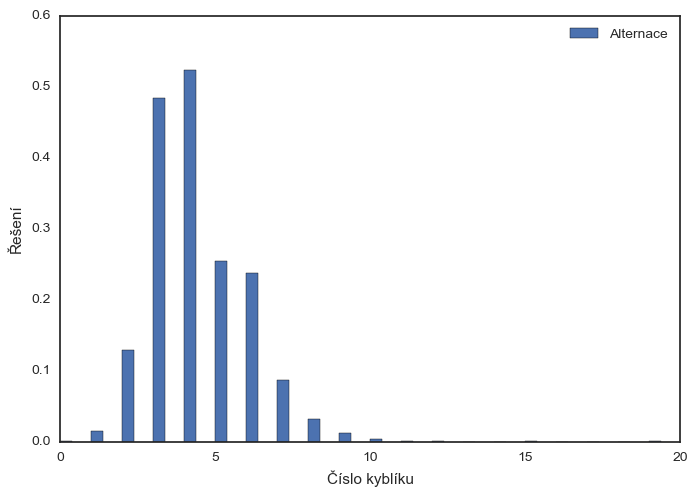

<function __main__.plot_histogram>

In [25]:
def plot_histogram(task1, task2, bin_count=20):
    # Histrogram se da zobrazit mnohem jednoduseji,
    # ale zde chceme porovnat dve ulohy v jednom grafu.
    
    # nejprve profiltrujeme data na pozadovane 2 ulohy
    data = programs[programs['problem_name'].isin({task1, task2})]
    # take je potreba se zbavit chybnych zaznamu
    data = data[data['time'] > 0]
    # pro kazdou ulohu si napocitame histogram,
    # a pak jej vykreslime
    for i, (task, task_data) in enumerate(data.groupby('problem_name')):
        # vypocet histogramu
        hist, bins = np.histogram(task_data['time_log'], bins=bin_count, normed=True)
        # vykresleni histogramu
        plt.bar(
            np.arange(0, len(hist)) + 0.4 * i,
            hist,
            width=0.4,
            color=sns.color_palette()[i * 2],
            label=task
        )
    plt.xlabel('Číslo kyblíku')
    plt.ylabel('Řešení')
    plt.legend(loc='upper right')
    plt.show()

# nasleduje kod, ktery vytvari interaktivni prvky
task1 = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='První úloha:',
    disabled=False
)
task2 = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='Druhá úloha:',
    disabled=False
)
bin_count = widgets.IntSlider(value=20, min=5, max=50, description="Počet kyblíků")
widgets.interact(plot_histogram, task1=task1, task2=task2, bin_count=bin_count)

### 2. Úkol: Porovnání všech úloh pomocí scatter plotu

<function __main__.plot_scatter>

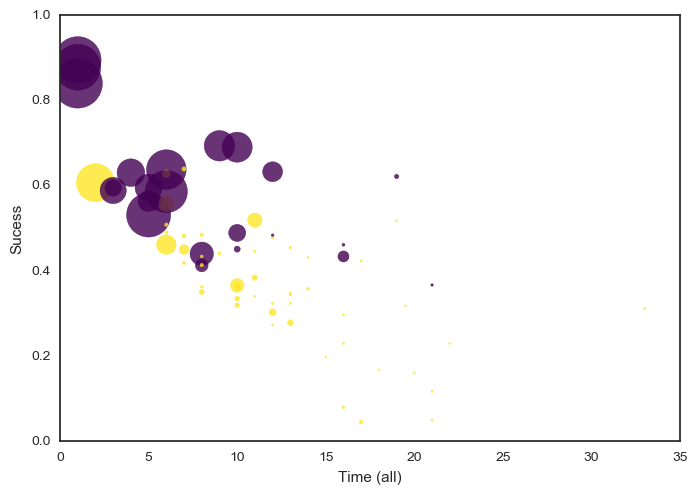

In [26]:
def plot_scatter(sample_size):
    data = problems[problems['problem_name'].isin(random.sample(list(programs['problem_name'].unique()), sample_size))]
    size = 2 + np.pi * (20 * data['users'] / data['users'].max()) ** 2
    cmap = get_cmap('viridis')
    plt.scatter(data['time_all'], data['success'], s=size, color=cmap(data['recursion_correct']), alpha=0.8)
    plt.xlabel('Time (all)')
    plt.ylabel('Sucess')
    plt.ylim(0, 1)
    plt.xlim(0, plt.xlim()[1])
    
problem_count = len(programs['problem_id'].unique())
sample_size = widgets.IntSlider(min=10, max=problem_count, value=problem_count, description='Velikost vzorku')
widgets.interact(plot_scatter, sample_size=sample_size)

### 3. Úkol: Porovnání všech úloh pomocí pair gridu

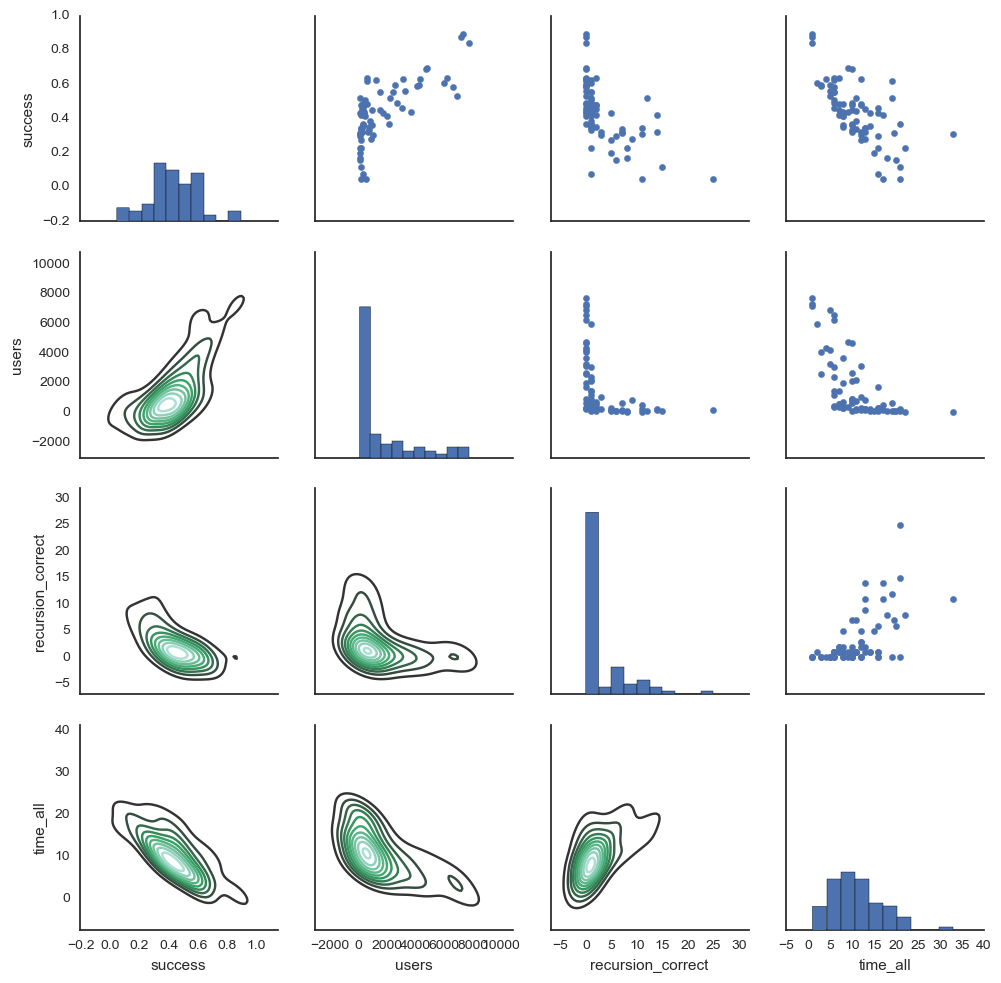

In [27]:
g = sns.PairGrid(problems[['success', 'users', 'recursion_correct', 'time_all']])
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

### 4. Úkol: Porovnání více úloh pomocí violinplotu

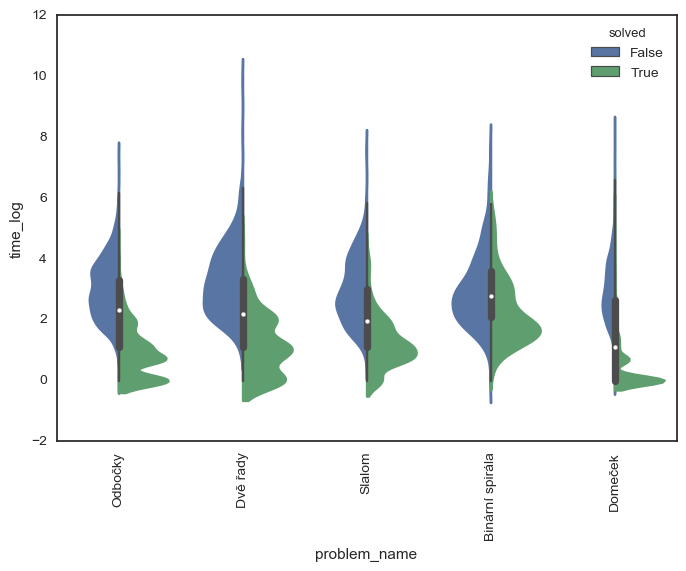

In [28]:
to_plot = programs[programs['problem_name'].isin(random.sample(list(programs['problem_name'].unique()), 5))]
sns.violinplot(x='problem_name', y='time_log', hue='solved', split=True, data=to_plot)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### 5. Úkol: Navštívená pole

/home/jpapouse/python-virtualenv/robotanik/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


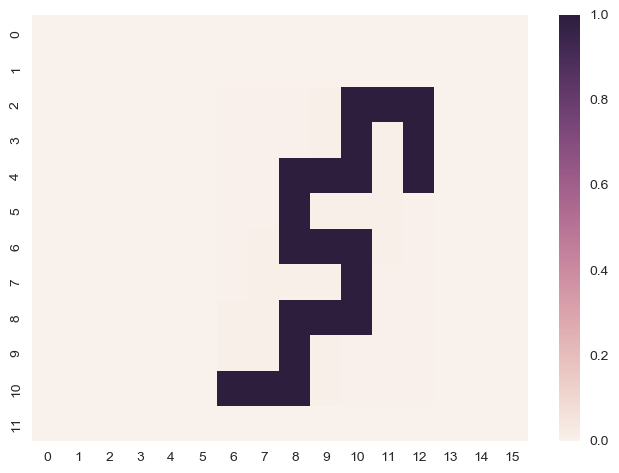

In [29]:
def plot_heatmap(task, correct=True):
    data = programs[programs['problem_name'] == task]
    data = data[data['solved'] == correct]
    visited_matrix = np.zeros((12, 16))
    for visited in data['visited'].values:
        for row, col in visited:
            visited_matrix[row, col] += 1
    sns.heatmap(visited_matrix / visited_matrix.max())

# nasleduje kod, ktery vytvari interaktivni prvky
task = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='Úloha:',
    disabled=False
)
correct = widgets.Checkbox(description='Správná řešení')
widgets.interact(plot_heatmap, task=task, correct=correct)

## Strojové učení
TBA

In [7]:
times = pd.read_csv('data/robotanik-user-problem-time.csv', index_col=0)

In [8]:
# Mame kolem 9000 uzivatelu (radky) a 80 uloh (sloupce)
times.shape

(9161, 78)

In [9]:
# Kazda uloha ma svuj identifikator
times.columns

Index(['635', '636', '637', '638', '639', '640', '641', '642', '643', '644',
       '645', '646', '647', '648', '649', '650', '651', '652', '653', '654',
       '655', '656', '657', '658', '659', '660', '661', '662', '663', '664',
       '665', '666', '667', '668', '669', '670', '671', '672', '673', '674',
       '675', '676', '677', '678', '679', '680', '681', '682', '683', '696',
       '697', '698', '699', '700', '701', '702', '703', '704', '705', '706',
       '1119', '1120', '1121', '1122', '1123', '1124', '1125', '1401', '1402',
       '1403', '1404', '1405', '1406', '1407', '1704', '1705', '1706', '1707'],
      dtype='object')

In [10]:
# Prvnich par radku matice vypada takto (NaN = "not a number" - uzivatel danou ulohu neresil/nevyresil)
times.head()

635   636   637   638    639    640   641   642   643    644  ...   \
Login                                                                 ...    
 U1    25.0  13.0  14.0  38.0    NaN  459.0   NaN   NaN   NaN  132.0  ...    
 U2    10.0   5.0  49.0  19.0   92.0   23.0  57.0  40.0  42.0  211.0  ...    
 U4    26.0   6.0   NaN   NaN    NaN    NaN   NaN   NaN   NaN    NaN  ...    
 U5    52.0  39.0  25.0  19.0  364.0   25.0  99.0   NaN  56.0   46.0  ...    
 U6    68.0  20.0  32.0  18.0    NaN   42.0   NaN   NaN   NaN    NaN  ...    

       1402  1403  1404  1405  1406  1407   1704   1705  1706  1707  
Login                                                                
 U1     NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  
 U2     NaN   NaN   NaN   NaN   NaN   NaN  185.0  113.0  36.0  73.0  
 U4     NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  
 U5     NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  
 U6     NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  

[5 rows x 78 columns]